In [1]:
!pip install pmdarima
!pip install alpha_vantage

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to b

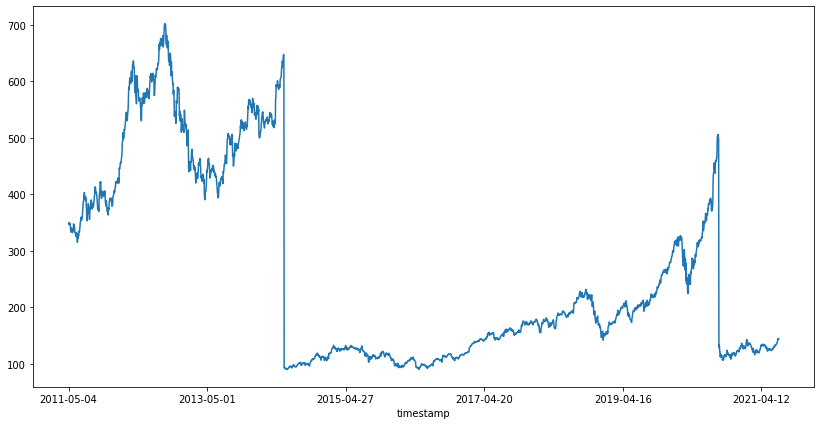

In [3]:
key='DUQG7U14LK4C3BT2'
# key = '5Y3MCR5FPN0GYZGO'
apiKey = key
ticker = 'AAPL'

df_temp = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&apikey='+apiKey+'&outputsize=full&datatype=csv') 
ma5 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=5&series_type=close&apikey='+apiKey+'&datatype=csv')
ma30 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=30&series_type=close&apikey='+apiKey+'&datatype=csv')
ma180 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=180&series_type=close&apikey='+apiKey+'&datatype=csv')
atr = pd.read_csv('https://www.alphavantage.co/query?function=ATR&symbol='+ticker+'&interval=daily&time_period=14&apikey='+apiKey+'&datatype=csv&outputsize=full')


ma5 = ma5.truncate( after = 2564)
ma30 = ma30.truncate( after = 2564)
ma180= ma180.truncate( after = 2564)
df_temp = df_temp.truncate( after = 2564)
atr = atr.truncate(after = 2564)
df = df_temp.copy()
df['atr'] = atr['ATR']
df['ma5'] = ma5['EMA']
df['ma30'] = ma30['EMA']
df['ma180'] = ma180['EMA']
#now df has 10 columns with diff daily feature data

df.isnull().values.any()

import time
# time.sleep(60)
key = '5Y3MCR5FPN0GYZGO'
apiKey= key
rsi = pd.read_csv('https://www.alphavantage.co/query?function=RSI&symbol='+ticker+'&interval=daily&time_period=14&series_type=open&apikey='+apiKey+'&datatype=csv')
rsi['time'][0] = rsi['time'][0].split()[0]
obv = pd.read_csv('https://www.alphavantage.co/query?function=OBV&symbol='+ticker+'&interval=daily&apikey='+apiKey+'&datatype=csv')
obv['time'][0] = obv['time'][0].split()[0]
macd = pd.read_csv('https://www.alphavantage.co/query?function=MACD&symbol='+ticker+'&interval=daily&series_type=open&apikey='+apiKey+'&datatype=csv')
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol='+ticker+'&apikey='+apiKey

import requests
r = requests.get(url)
data = r.json()
eps_list = data['quarterlyEarnings']
eps = pd.DataFrame(columns=['date', 'eps'])
for i in range(len(eps_list)):
    eps.loc[i] = [eps_list[i]['reportedDate'],eps_list[i]['reportedEPS']]
rsi = rsi.truncate(after = 2564)
obv = obv.truncate(after = 2564)
macd = macd.truncate(after = 2564)
eps = eps.truncate(after = 2564)
df['rsi'] = rsi['RSI']
df['obv'] =  obv['OBV']
df['macd'] = macd['MACD_Hist']

df.set_index('timestamp',drop = True, inplace = True)
eps.set_index('date',drop = True, inplace = True)
df['eps'] = eps['eps']
df.reset_index(inplace =True)
eps.reset_index(inplace  = True)
row = 0

for i in range(len(df)):
    if(pd.isnull(df['eps'][i])):
        df['eps'][i] = eps['eps'][row]
    else:
        row = row+1
temp=pd.DataFrame()
temp['time']=df['timestamp']
temp['senti']=np.nan
temp['prev']=np.nan
index_eps=0
# print(eps['eps'][1])
for i in range(len(df)-1):
    temp['senti'][i]=0.99
    temp['prev'][i]=df['close'][i+1]
# df['eps']=temp['eps']
df['senti']=temp['senti']
df['prev']=temp['prev']
df = df[:-1]
    
#now df has 14 columns with diff daily feature data for the past 2 years

df =df.iloc[::-1]

df.set_index("timestamp", drop=False, inplace=True)

df.head()

"""Plotting the target variable **close** over time"""

df.close.plot(figsize=(14, 7))

In [4]:
df.drop(['prev'],axis = 1, inplace= True)

df.reset_index(drop=True, inplace=True)
lag_features = ["high", "low", "volume", "atr","rsi","obv","macd",
                #"prev"
               ]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("timestamp", drop=False, inplace=True)
df.head()

"""For boosting models, it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information but we could do so and we will in this notebook so that all models are compared on the exact same set of features."""

df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")
df["month"] = df.timestamp.dt.month
df["week"] = df.timestamp.dt.week
df["day"] = df.timestamp.dt.day
df["day_of_week"] = df.timestamp.dt.dayofweek
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,timestamp,open,high,low,close,volume,atr,ma5,ma30,ma180,rsi,obv,macd,eps,senti,high_mean_lag3,high_mean_lag7,high_mean_lag30,high_std_lag3,high_std_lag7,high_std_lag30,low_mean_lag3,low_mean_lag7,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30,atr_mean_lag3,atr_mean_lag7,atr_mean_lag30,atr_std_lag3,atr_std_lag7,atr_std_lag30,rsi_mean_lag3,rsi_mean_lag7,rsi_mean_lag30,rsi_std_lag3,rsi_std_lag7,rsi_std_lag30,obv_mean_lag3,obv_mean_lag7,obv_mean_lag30,obv_std_lag3,obv_std_lag7,obv_std_lag30,macd_mean_lag3,macd_mean_lag7,macd_mean_lag30,macd_std_lag3,macd_std_lag7,macd_std_lag30,month,week,day,day_of_week
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-04,2011-05-04,348.26,351.83,346.8800,349.57,13901800,0.1873,10.6998,10.5687,9.7960,53.4313,9.284103e+10,0.0315,0.2275,0.99,266.878479,267.040466,267.994873,3.132293,5.390427,13.752284,261.654846,261.816406,262.758026,3.364357,5.689978,13.974726,37449980.0,37382868.0,37097360.0,8168182.500,1.030012e+07,1.321828e+07,0.931407,0.929831,0.920811,0.023982,0.041751,0.105331,55.497849,55.479832,55.419968,3.071599,4.488567,7.986443,9.109733e+10,9.109553e+10,9.108548e+10,191784496.0,271630336.0,564741376.0,0.003797,0.003112,0.0004,0.044270,0.082169,0.181613,5,18,4,2
2011-05-05,2011-05-05,348.40,350.95,346.0500,346.75,11998900,0.1847,10.6824,10.5738,9.8054,53.5563,9.250506e+10,0.0259,0.2275,0.99,351.829987,351.829987,351.829987,3.132293,5.390427,13.752284,346.880005,346.880005,346.880005,3.364357,5.689978,13.974726,13901800.0,13901800.0,13901800.0,8168182.500,1.030012e+07,1.321828e+07,0.187300,0.187300,0.187300,0.023982,0.041751,0.105331,53.431301,53.431301,53.431301,3.071599,4.488567,7.986443,9.284103e+10,9.284103e+10,9.284103e+10,191784496.0,271630336.0,564741376.0,0.031500,0.031500,0.0315,0.044270,0.082169,0.181613,5,18,5,3
2011-05-06,2011-05-06,349.69,350.00,346.2100,346.66,10004800,0.1798,10.6699,10.5784,9.8147,54.7615,9.222492e+10,0.0233,0.2275,0.99,351.390015,351.390015,351.390015,0.622254,0.622254,0.622254,346.464996,346.464996,346.464996,0.586899,0.586899,0.586899,12950350.0,12950350.0,12950350.0,1345553.500,1.345554e+06,1.345554e+06,0.186000,0.186000,0.186000,0.001838,0.001838,0.001838,53.493801,53.493801,53.493801,0.088388,0.088388,0.088388,9.267304e+10,9.267304e+10,9.267304e+10,237566336.0,237566336.0,237566336.0,0.028700,0.028700,0.0287,0.003960,0.003960,0.003960,5,18,6,4
2011-05-09,2011-05-09,347.86,349.20,346.5276,347.60,7312400,0.1728,10.6712,10.5846,9.8242,52.6733,9.242967e+10,0.0165,0.2275,0.99,350.926666,350.926666,350.926666,0.915223,0.915223,0.915223,346.380005,346.380005,346.380005,0.440341,0.440341,0.440341,11968500.0,11968500.0,11968500.0,1948677.875,1.948678e+06,1.948678e+06,0.183933,0.183933,0.183933,0.003808,0.003808,0.003808,53.916367,53.916367,53.916367,0.734571,0.734571,0.734571,9.252367e+10,9.252367e+10,9.252367e+10,308473504.0,308473504.0,308473504.0,0.026900,0.026900,0.0269,0.004190,0.004190,0.004190,5,19,9,0
2011-05-10,2011-05-10,348.89,349.69,346.6600,349.45,10074700,0.1671,10.6910,10.5940,9.8342,53.7425,9.271176e+10,0.0131,0.2275,0.99,350.049988,350.494995,350.494995,0.876071,1.141826,1.141826,346.262543,346.416901,346.416901,0.243095,0.367033,0.367033,9772033.0,10804475.0,10804475.0,2351904.750,2.819819e+06,2.819819e+06,0.179100,0.181150,0.181150,0.005981,0.006376,0.006376,53.663700,53.605598,53.605598,1.048235,0.863732,0.863732,9.238655e+10,9.250016e+10,9.250016e+10,144959872.0,256215168.0,256215168.0,0.021900,0.024300,0.0243,0.004854,0.006225,0.006225,5,19,10,1


In [5]:
df_train = df[df.timestamp < "2019"]
df_valid = df[df.timestamp >= "2019"]

len_predict = len(df[df.timestamp >= "2021"])

df_train.info()

df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1928 entries, 2011-05-04 to 2018-12-31
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          1928 non-null   datetime64[ns]
 1   open               1928 non-null   float64       
 2   high               1928 non-null   float64       
 3   low                1928 non-null   float64       
 4   close              1928 non-null   float64       
 5   volume             1928 non-null   int64         
 6   atr                1928 non-null   float64       
 7   ma5                1928 non-null   float64       
 8   ma30               1928 non-null   float64       
 9   ma180              1928 non-null   float64       
 10  rsi                1928 non-null   float64       
 11  obv                1928 non-null   float64       
 12  macd               1928 non-null   float64       
 13  eps                1928 non-null   object        
 14

In [6]:
exogenous_features = ["high_mean_lag3", "high_std_lag3", "low_mean_lag3", "low_std_lag3",
                      "volume_mean_lag3", "volume_std_lag3", "atr_mean_lag3",
                    "atr_std_lag3",
                     "rsi_mean_lag3",
                      "rsi_std_lag3","obv_mean_lag3",
                      "obv_std_lag3","macd_mean_lag3",
                      "macd_std_lag3",
                      #"prev_mean_lag3","prev_std_lag3",
                      "high_mean_lag7", "high_std_lag7", "low_mean_lag7", "low_std_lag7",
                      "volume_mean_lag7", "volume_std_lag7", "atr_mean_lag7",
                      "atr_std_lag7",
                      "rsi_mean_lag7", 
                      "rsi_std_lag7","obv_mean_lag7", "obv_std_lag7",
                      "macd_mean_lag7", "macd_std_lag7",
                      #"prev_mean_lag7","prev_std_lag7",
                      "high_mean_lag30", "high_std_lag30", "low_mean_lag30", "low_std_lag30",
                      "volume_mean_lag30", "volume_std_lag30", "atr_mean_lag30",
                      "atr_std_lag30",
                      "rsi_mean_lag30", "rsi_std_lag30","obv_mean_lag30", "obv_std_lag30",
                      "macd_mean_lag30", "macd_std_lag30",
                      #"prev_mean_lag30","prev_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [7]:
model = auto_arima(df_train.close,exogenous=df_train[exogenous_features],  trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train["close"],exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid),exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15865.325, Time=10.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16013.544, Time=6.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15904.404, Time=6.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15872.350, Time=8.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28668.396, Time=6.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15863.376, Time=9.68 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=15861.835, Time=9.77 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=15863.396, Time=10.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15863.367, Time=9.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=15865.280, Time=10.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=15859.824, Time=9.83 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15870.338, Time=9.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15861.360, Time=10.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=15861.389, Time=9.78 sec
 ARIMA(1,0,1)(0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


RMSE of Auto ARIMAX: 19.212501789743946

MAE of Auto ARIMAX: 10.175790588712234
MAPE: 6.152415700993773 %
MDAPE: 3.3303140583342037 %


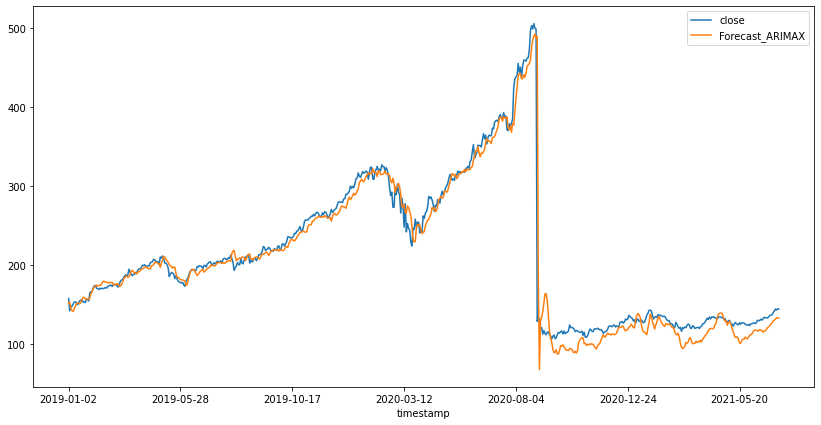

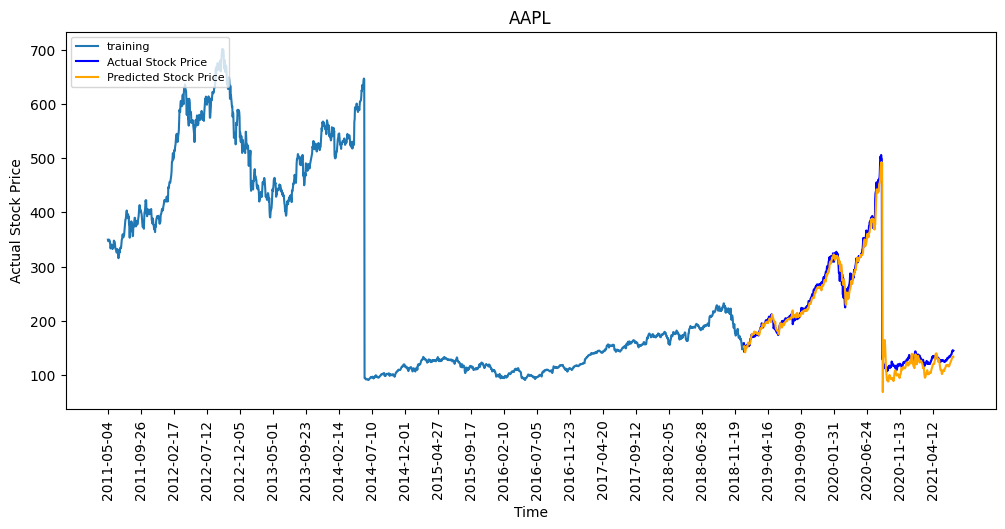

In [8]:
df_valid[["close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
#plot for timestamp>2020 only

print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.close, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.close, df_valid.Forecast_ARIMAX))

mape = np.mean(np.abs(df_valid.Forecast_ARIMAX - df_valid.close)/np.abs(df_valid.close))
print('MAPE: '+str(mape*100) + ' %')

mdape = np.median(np.abs(df_valid.Forecast_ARIMAX - df_valid.close)/np.abs(df_valid.close))
print('MDAPE: '+str(mdape*100) + ' %')

fc_series = pd.Series(df_valid.Forecast_ARIMAX, index=df_valid.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train['close'], label='training')
plt.plot(df_valid['close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title(ticker)
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(np.arange(0,(len(df_train)+ len(df_valid)),100))
plt.xticks( rotation ='vertical')
plt.show()

In [9]:
import math
import numpy as np 
import pandas as pd 
import time
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
# from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import keras
import tensorflow
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler
#new
import requests

In [10]:
df_valid.info()

df_valid.reset_index(inplace= True,drop = True)

FEATURES = ['timestamp','high', 'low', 'open', 'close', 'volume', 'atr','ma5','ma30','ma180', 'rsi', 'obv', 'macd', 'eps','senti','month', 'week','day','day_of_week']
# print('FEATURE LIST')
# print([f for f in FEATURES])
data_filtered = df_valid[FEATURES]
# Create the dataset with features and filter the data to the list of FEATURES

# data_filtered['residue']  = df_valid['Forecast_ARIMAX']
data_filtered['residue']= df_valid['Forecast_ARIMAX'] - df_valid['close']

data_filtered = data_filtered.reset_index(drop = True)

data_filtered.drop('timestamp',axis = 1, inplace = True)

data_filtered.info()



data_filtered_fin = data_filtered.copy()

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['residue'] 

#SCALING
# Calculate the number of rows in the data
nrows = data_filtered.shape[0]
np_data_unscaled = np.array(data_filtered)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Residue = pd.DataFrame(data_filtered_ext['residue'])
np_Residue_scaled = scaler_pred.fit_transform(df_Residue)

#SPLITTING
#Settings
sequence_length = 100

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
#train_data_len_fin = math.ceil(np_data.shape[0] * 0.8) #2616
train_data_len_fin= len(df_Residue) - len_predict 


# Create the training data
train_data = np_data[0:train_data_len_fin, :]
x_train, y_train = [], []

# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(100, train_data_len_fin):
    x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len_fin - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columns
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test_fin = np.array(x_test); y_test = np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test_fin.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 2019-01-02 to 2021-07-12
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          636 non-null    datetime64[ns]
 1   open               636 non-null    float64       
 2   high               636 non-null    float64       
 3   low                636 non-null    float64       
 4   close              636 non-null    float64       
 5   volume             636 non-null    int64         
 6   atr                636 non-null    float64       
 7   ma5                636 non-null    float64       
 8   ma30               636 non-null    float64       
 9   ma180              636 non-null    float64       
 10  rsi                636 non-null    float64       
 11  obv                636 non-null    float64       
 12  macd               636 non-null    float64       
 13  eps                636 non-null    object        
 14 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=False, 
               input_shape=(x_train.shape[1], x_train.shape[2]))) 
# model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
epochs = 12

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs)


1900 100 19
Epoch 1/12
26/26 [==============================] - 17s 84ms/step - loss: 0.4621
Epoch 2/12
26/26 [==============================] - 2s 81ms/step - loss: 0.1177
Epoch 3/12
26/26 [==============================] - 2s 82ms/step - loss: 0.1211
Epoch 4/12
26/26 [==============================] - 2s 82ms/step - loss: 0.0919
Epoch 5/12
26/26 [==============================] - 2s 81ms/step - loss: 0.0769
Epoch 6/12
26/26 [==============================] - 2s 82ms/step - loss: 0.0935
Epoch 7/12
26/26 [==============================] - 2s 83ms/step - loss: 0.0825
Epoch 8/12
26/26 [==============================] - 2s 84ms/step - loss: 0.1322
Epoch 9/12
26/26 [==============================] - 2s 85ms/step - loss: 0.0977
Epoch 10/12
26/26 [==============================] - 2s 86ms/step - loss: 0.0983
Epoch 11/12
26/26 [==============================] - 2s 87ms/step - loss: 0.0799
Epoch 12/12
26/26 [==============================] - 2s 87ms/step - loss: 0.0764


In [12]:
date_index_fin = df_valid['timestamp']

# Get the predicted values-+*/
predictions = model.predict(x_test_fin)
 
# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(predictions)


# Add the date column
data_filtered_sub = data_filtered_fin.copy()
data_filtered_sub['Date'] = date_index_fin

data_filtered_sub

train = data_filtered_sub[:train_data_len_fin + 1]
valid = data_filtered_sub[train_data_len_fin:]

valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["residue"], True)

valid.info()

train.info()

valid.insert(1,'final_pred',df_valid['Forecast_ARIMAX']- valid['Prediction'])

train.insert(1,"final_pred", df_valid['Forecast_ARIMAX'] - train['residue'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 505 to 635
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   high         131 non-null    float64       
 1   Difference   131 non-null    float64       
 2   Prediction   131 non-null    float32       
 3   low          131 non-null    float64       
 4   open         131 non-null    float64       
 5   close        131 non-null    float64       
 6   volume       131 non-null    int64         
 7   atr          131 non-null    float64       
 8   ma5          131 non-null    float64       
 9   ma30         131 non-null    float64       
 10  ma180        131 non-null    float64       
 11  rsi          131 non-null    float64       
 12  obv          131 non-null    float64       
 13  macd         131 non-null    float64       
 14  eps          131 non-null    object        
 15  senti        131 non-null    float64       
 16  month 

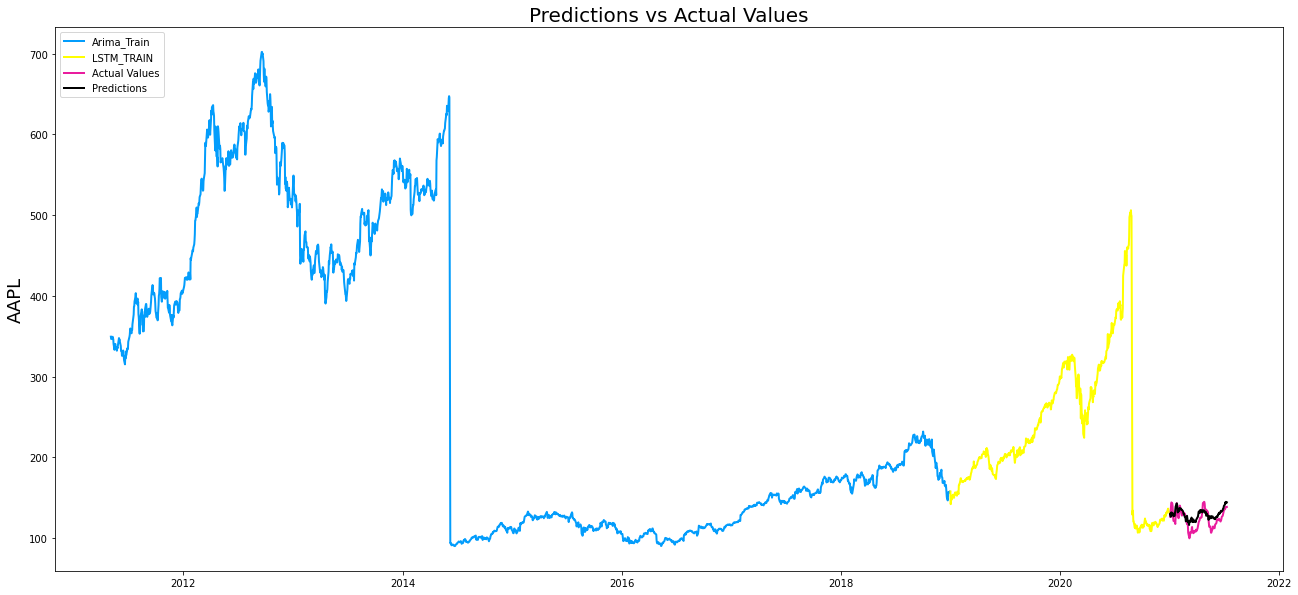

In [13]:
old_df =  df[df.timestamp < "2019"]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xo = old_df['timestamp']
yo = old_df[['close']]
# train['timestamp']=train['Date']
# valid['timestamp']=valid['Date']
xt = train['Date']; yt = train[["close"]]
xv = valid['Date']; yv = valid[["close", "final_pred"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(ticker, fontsize=18)
# plt.plot(xo, yo, color="yellow", linewidth=2.0)
# xt.xaxis_date() 
# xv.xaxis_date() 
plt.plot(xo, yo, color="#039dfc", linewidth=2.0)
plt.plot(train.Date, yt, color="yellow", linewidth=2.0)
plt.plot(valid.Date, yv["final_pred"], color="#E91D9E", linewidth=2.0)
plt.plot(valid.Date, yv["close"], color="black", linewidth=2.0)
# plt.xticks( rotation ='vertical')
# size = len(yt) + len(yv)
# plt.xticks(np.arange(0,size,50))
plt.legend(["Arima_Train", "LSTM_TRAIN", "Actual Values","Predictions"], loc="upper left")

In [14]:
MAPE = np.mean((np.abs(valid['Difference']/ valid['close']))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(valid['Difference']/ valid['close'])) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')


Mean Absolute Percentage Error (MAPE): 6.51 %
Median Absolute Percentage Error (MDAPE): 6.17 %
